In [34]:
from jw_utils import file_utils as fu
import plotly.graph_objects as go
import plotly.offline as pyo
import numpy as np
from Bio import Phylo
import pandas as pd
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from jw_utils import jw_draw_tree
import plotly.offline as pyo
import os
import json
from jw_utils import ncbi_utils as nu
from plotly.subplots import make_subplots
import shutil
import plotly.io as pio

### Download summaries for all annotated genomes in taxon 470 (baumannii) in ncbi datasets genome database

In [ ]:
#!datasets summary genome --annotated  taxon 470 --assembly-source refseq > summary_all.json

In [2]:
summary_df = nu.make_summary_df('./summary_all.json')
reform_summary_d = nu.parse_ncbi_summary('./summary_all.json')

### Filter out assemblies in bottom 50% of n50  
- I may skip this step or at least reduce it. In the future, and instead, during the deduplication of matrix in the next notebook, I   
    will not randomly pick genomes for psosible discard. Instead, I will start with the lowest quality assemblies and see if they can be discarded. 

In [ ]:
reform_summary_d['GCF_009035845.1']['assembly_stats']

In [14]:
## filter out poor quality assemblies
 # fraction to throw out
def filter_out_lowest_n50genomes(reform_summary_d, thresh):
    """throw out genomes that fall below thresh and write accessions to file"""
    n50_filt = {}
    n50 = {}
    for acc, summ_dict in reform_summary_d.items():
        n50_val = summ_dict['assembly_stats']['contig_n50']
        n50[acc] = n50_val
    
    df  = pd.DataFrame.from_dict(n50, orient='index').sort_values(0)
    df.columns = ['contig_n50']
    print(f'accessions before filtering: {df.shape[0]}')
    df = df.iloc[int(df.shape[0] * thresh):,:]
    print(f'accessions after filtering: {df.shape[0]}')
    with open('accessions.txt', 'w') as f:
        for acc in df.index:
            f.write(acc + '\n')
    return df, n50

thresh = 0.3
accessions_df, n50 =  filter_out_lowest_n50genomes(reform_summary_d,thresh )

accessions before filtering: 9785
accessions after filtering: 6850


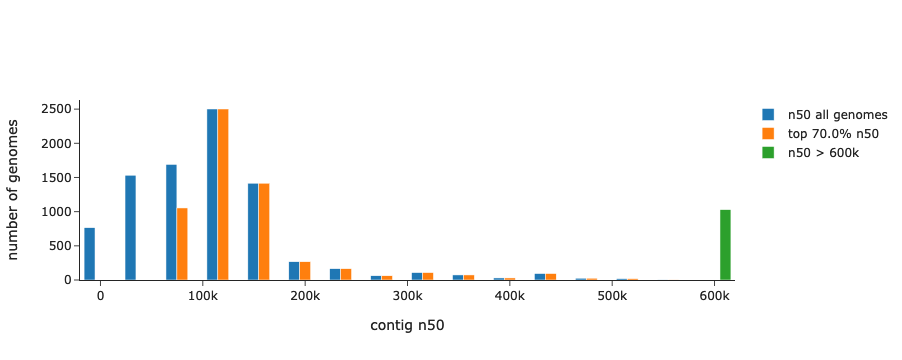

In [36]:
def make_n50_distribution_fig(accessions_df, n50):
    """"""
    y,x =                       np.histogram(list(n50.values()), range = [0,600000], bins = 15)
    y_high, x_high =            np.histogram(list(n50.values()), range = [600000,50000000], bins = 1)
    y_filt , x_filt =           np.histogram(accessions_df['contig_n50'], range = [0,600000], bins = 15)
    y_filt_high , x_filt_high = np.histogram(accessions_df['contig_n50'], range = [600000,50000000], bins = 1)
    
    trace_all =  go.Bar(x = x,y=  y, name = 'n50 all genomes')
    trace_filt = go.Bar(x = x_filt,y= y_filt, name = f'top {(1-thresh)*100}% n50')
    
    trace_all_high = go.Bar(x = x_high,y= y_high, name = 'n50 > 600k')
    fig = go.Figure(data = [trace_all, trace_filt, trace_all_high])
    fig.update_yaxes(title = 'number of genomes')
    fig.update_xaxes(title = 'contig n50')
    fig.update_layout(template = 'simple_white')
    return fig


fig=make_n50_distribution_fig(accessions_df, n50)
os.makedirs(f'./figures', exist_ok=True)
pio.write_image(fig, os.path.join(f'genome_filtering_top{(1-thresh)*100}_perc.png'))
fig

### Download all assemblies that met n50 filter from NCBI datasets  
` !datasets download genome --exclude-gff3 --exclude-rna accession --dehydrated --inputfile accessions.txt`  
Extract the zip file, then...  
` !datasets rehydrate --directory ncbi_dataset`

In [ ]:
#nu.download_genomes_from_accfile('./accessions.txt',files_to_include='genome,protein', dataset_fp='ncbi_dataset.zip')

In [26]:
def _make_genome_sketches(genome_dir):
    genome_paths = [os.path.join(genome_dir,g) for g in os.listdir(genome_dir) if g.endswith('.fna')]
    out_dir = f'{len(genome_paths)}_genome_sketches'
    os.makedirs(out_dir, exist_ok=True)
    for fp in genome_paths:
        name = fp.split('/')[-1].replace('.fna', '.msh')
        outpath = os.path.join(out_dir, name)
        !mash sketch $fp -o $outpath
    return out_dir


def _write_fp_textfile(sketch_file_dir):
    with open('./sketch_files.txt', 'w') as f:
        for file in os.listdir(sketch_file_dir):
            f.write(sketch_file_dir + '/' + file + '\n')

            
def _mash_output_to_dataframe(dist_mat_path):
    """Return bottom triangle df from bottom triangle tab-delimeted text file"""
    with open(dist_mat_path, 'r') as f: 
        triangle = f.readlines()
    col_names = []

    num_cols_rows  = int(triangle[0][1:-1])
    triangle = triangle[1:]
    dist_matrix = np.full([len(triangle),len(triangle)], np.nan)
    index_col_names = []
    for i, row in enumerate(triangle):
        row_list = row.strip().split('\t')
        for col in range(num_cols_rows):
            if col == 0:
                name =  row_list[0].split('/')[-1][0:15]
                index_col_names.append(name)
            else:
                if col < len(row_list):
                    dist_matrix[i][col-1] = row_list[col]
    df = pd.DataFrame(dist_matrix, columns =  index_col_names)
    df.index = index_col_names
    return df            

            
def make_dist_matrix(genome_dir):
    print('making sketch files...')
    sketch_file_dir = _make_genome_sketches(genome_dir)
    print('writing text file...')
    _write_fp_textfile(sketch_file_dir)
    print('making distance matrix...')
    !mash triangle -l ./sketch_files.txt > dist_mat.txt
    df = _mash_output_to_dataframe('dist_mat.txt')
    return df
            

In [78]:
def move_proteomes(data_dir, proteome_dir = './Proteomes'):
    """"""
    os.makedirs(proteome_dir, exist_ok=True)
    no_proteome = []
    accs = [dir for dir in os.listdir(data_dir) if dir.startswith('GC')]
    for acc in accs:
        fp = os.path.join(data_dir, acc, 'protein.faa')
        if os.path.exists(fp):
            new_fp = os.path.join(proteome_dir, f'{acc}.faa')
            shutil.move(fp,new_fp )
        else:
            no_proteome.append(acc)
    return no_proteome



def move_genomes(data_dir, genome_dir = './Genomes'):
    """"""
    os.makedirs(genome_dir, exist_ok=True)
    no_genome = []
    accs = [dir for dir in os.listdir(data_dir) if dir.startswith('GC')]
    for acc in accs:
        for file in os.listdir(os.path.join(data_dir, acc)):
            if file.endswith('.fna'):
                print(file)
                fp = os.path.join(data_dir, acc, file)
                if os.path.exists(fp):
                    new_fp = os.path.join(genome_dir, f'{acc}.fna')
                    print(new_fp)
                    shutil.move(fp,new_fp )
                else:
                    no_genome.append(acc)
    return no_genome

data_dir = './ncbi_dataset/ncbi_dataset/data'
move_proteomes(data_dir, proteome_dir = './Proteomes')
move_genomes(data_dir, genome_dir = './Genomes')

### make genome sketches with min-Hash and generate a distance matrix file

In [38]:
#dist_matrix_df = make_dist_matrix(genome_dir='./Genomes')
dist_matrix_df = _mash_output_to_dataframe('dist_mat.txt')
dist_matrix_df.to_csv('./dist_mat.csv')